<a href="https://colab.research.google.com/github/vedantkamtikar/Stock-Price-Predictor/blob/main/Stockprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Price Predictor
by Vedant Kamtikar

In [ ]:
#Stock price predictor

In [ ]:
import math
import pandas_datareader as web
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#get the stocks of the past 365 days
#start = datetime.datetime(2020, 7, 31)
#end = datetime.datetime(2025, 7, 31)

df = yf.download('AAPL', start='2012-1-1', end='2025-8-1') #fetching from the internet
df


/tmp/ipython-input-3773605881.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2012-1-1', end='2025-8-1') #fetching from the internet
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.359183,12.397353,12.292163,12.304185,302220800
2012-01-04,12.425601,12.462869,12.300576,12.322215,260022000
2012-01-05,12.563551,12.579179,12.402460,12.470984,271269600
2012-01-06,12.694888,12.705407,12.599316,12.615846,318292800
2012-01-09,12.674750,12.855677,12.663329,12.788055,394024400
...,...,...,...,...,...
2025-07-25,213.880005,215.240005,213.399994,214.699997,40268800
2025-07-28,214.050003,214.850006,213.059998,214.029999,37858000


In [ ]:
# Number of rows and columns
df.shape

(3414, 5)

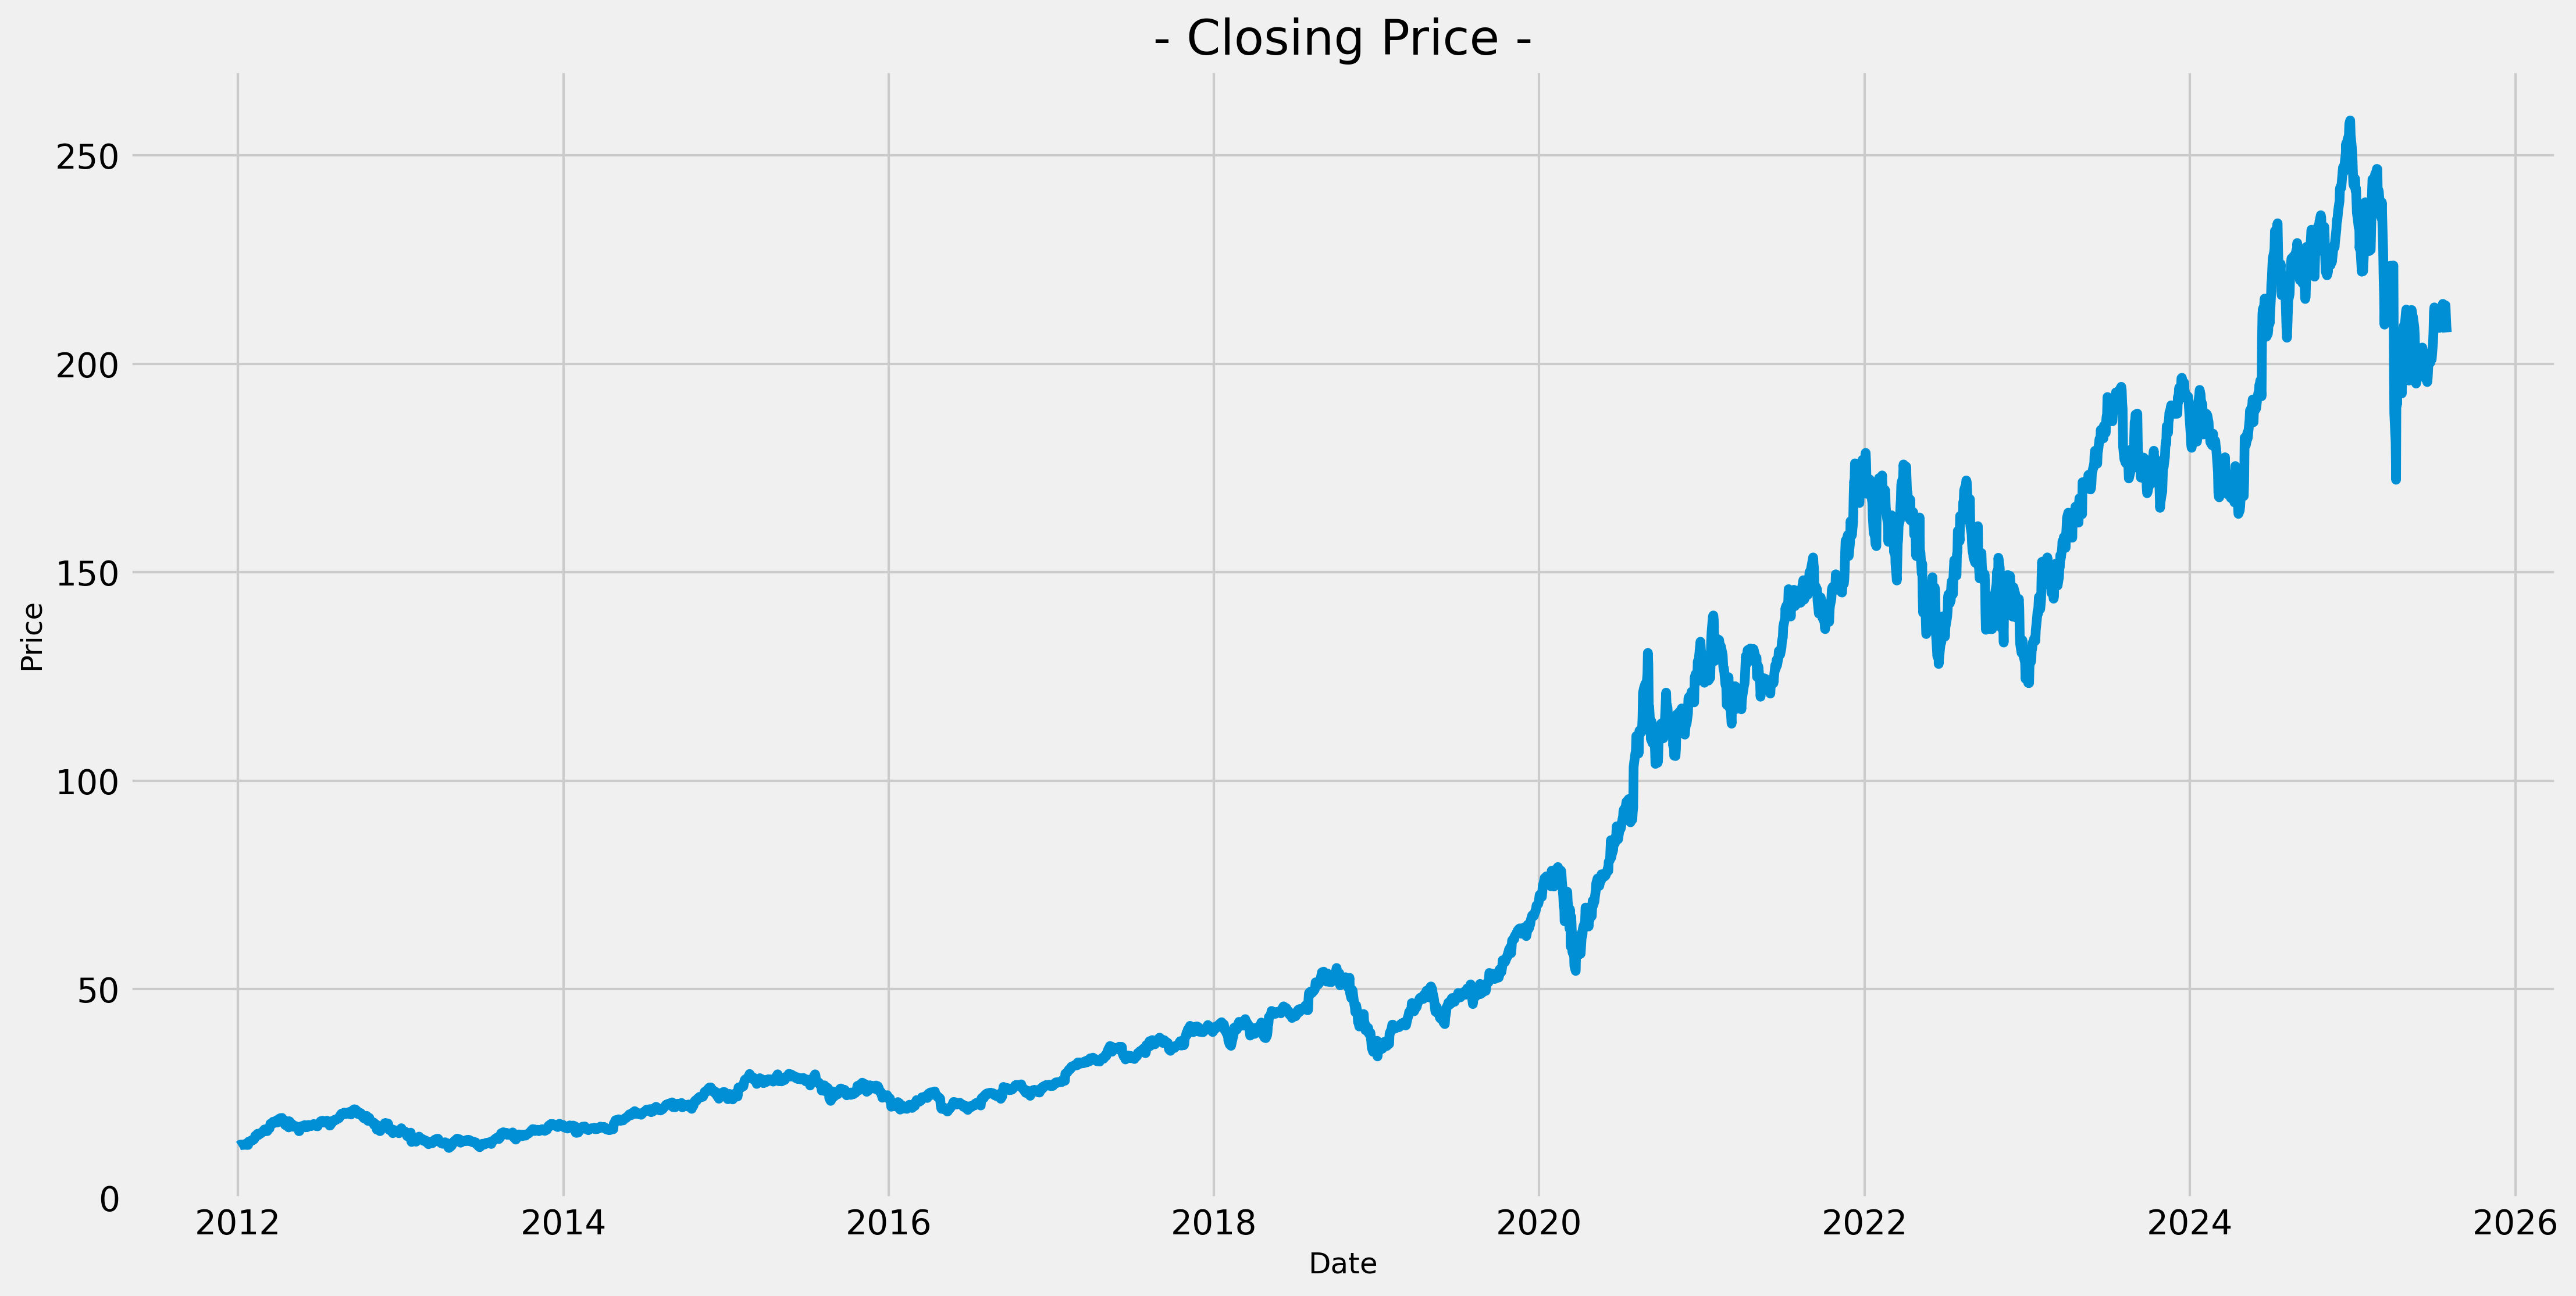

In [ ]:
# Plotting the data we recieved onto a graph
plt.figure(figsize=(16,8),dpi=300)
plt.title(" - Closing Price - ")
plt.plot(df['Close'])
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Price',fontsize = 12)
plt.show()

In [ ]:
# Here, we are defining the length of the closing price dataset
data = df.Close
dataset = data.values #converts the data into an array
training_data_len = math.ceil(len(dataset) * .80) #setting the training data length as 80% of total data
print(training_data_len, "elements of data will be used for training.")

2732 elements of data will be used for training.


In [ ]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1)) #Normalizing the data
scaled_data = scaler.fit_transform(dataset) #Bringing it to a range of (0,1), inclusive
print("Converted to array: \n")
scaled_data

Converted to array: 



array([[0.00182111],
       [0.00209057],
       [0.00265023],
       ...,
       [0.8088062 ],
       [0.79979962],
       [0.79379524]])

In [ ]:
# Training the model

# Keep in mind the trained_data_len was 80% of the total dataset.
# Using 80% for training the model.
# Here, " [0: training_data_len,  :] " takes the training data length (0.8) and returns all of the specified columns

training_data = scaled_data[0:training_data_len, :]
#splitting dataset
x_training = [] #independent training variables
y_training = [] #target variable

for i in range (60, len(training_data)):
    x_training.append(training_data[i-60:i, 0])
    y_training.append(training_data[i,0])

print(x_training)
print(y_training)
print()

[array([0.00182111, 0.00209057, 0.00265023, 0.00318307, 0.00310137,
       0.00328549, 0.00320135, 0.00305991, 0.00286726, 0.0034635 ,
       0.00400121, 0.00383541, 0.00292702, 0.00379395, 0.00294042,
       0.0061411 , 0.00589358, 0.00621671, 0.00691537, 0.00733846,
       0.0073031 , 0.00717264, 0.00772863, 0.00825172, 0.00884431,
       0.00980146, 0.0118121 , 0.01184259, 0.01296191, 0.01379834,
       0.01236078, 0.01291433, 0.01290336, 0.01445552, 0.01423486,
       0.0146433 , 0.01537733, 0.01578581, 0.01696244, 0.0178196 ,
       0.01806712, 0.01815366, 0.01668808, 0.01633451, 0.0163869 ,
       0.01776474, 0.01815246, 0.01898525, 0.02094834, 0.02356737,
       0.02307726, 0.02307845, 0.02497204, 0.02556464, 0.02514277,
       0.02475741, 0.02435629, 0.02568899, 0.02660345, 0.02698633]), array([0.00209057, 0.00265023, 0.00318307, 0.00310137, 0.00328549,
       0.00320135, 0.00305991, 0.00286726, 0.0034635 , 0.00400121,
       0.00383541, 0.00292702, 0.00379395, 0.00294042, 0.00

In [ ]:
x_training = np.array(x_training)
y_training = np.array(y_training)

x_training.shape

(2672, 60)

In [ ]:
x_training = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))
x_training.shape

(2672, 60, 1)

In [ ]:
#building lstm
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_training.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
 model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
#Training
model.fit(x_training, y_training, batch_size = 1, epochs = 1)

2672/2672 ━━━━━━━━━━━━━━━━━━━━ 78s 28ms/step - loss: 0.0012


In [ ]:
#Testing data set
#Creating an array with scaled values

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range (60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
#Converting the data into a numpy array so that we can use it in the LSTM model

x_test = np.array(x_test)


In [ ]:
#Reshaping
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# reshaping x_test, number of samples, number of time steps, number of features: closing price


In [ ]:
#Print the model's predictions based off of x_test dataset

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
#Evaluating the error using root mean squared

rmse = np.sqrt(np.mean((predictions - y_test) ** 2))

print("Accuracy =",(0.01*(100 - rmse)))

Accuracy = 0.9352476332422102


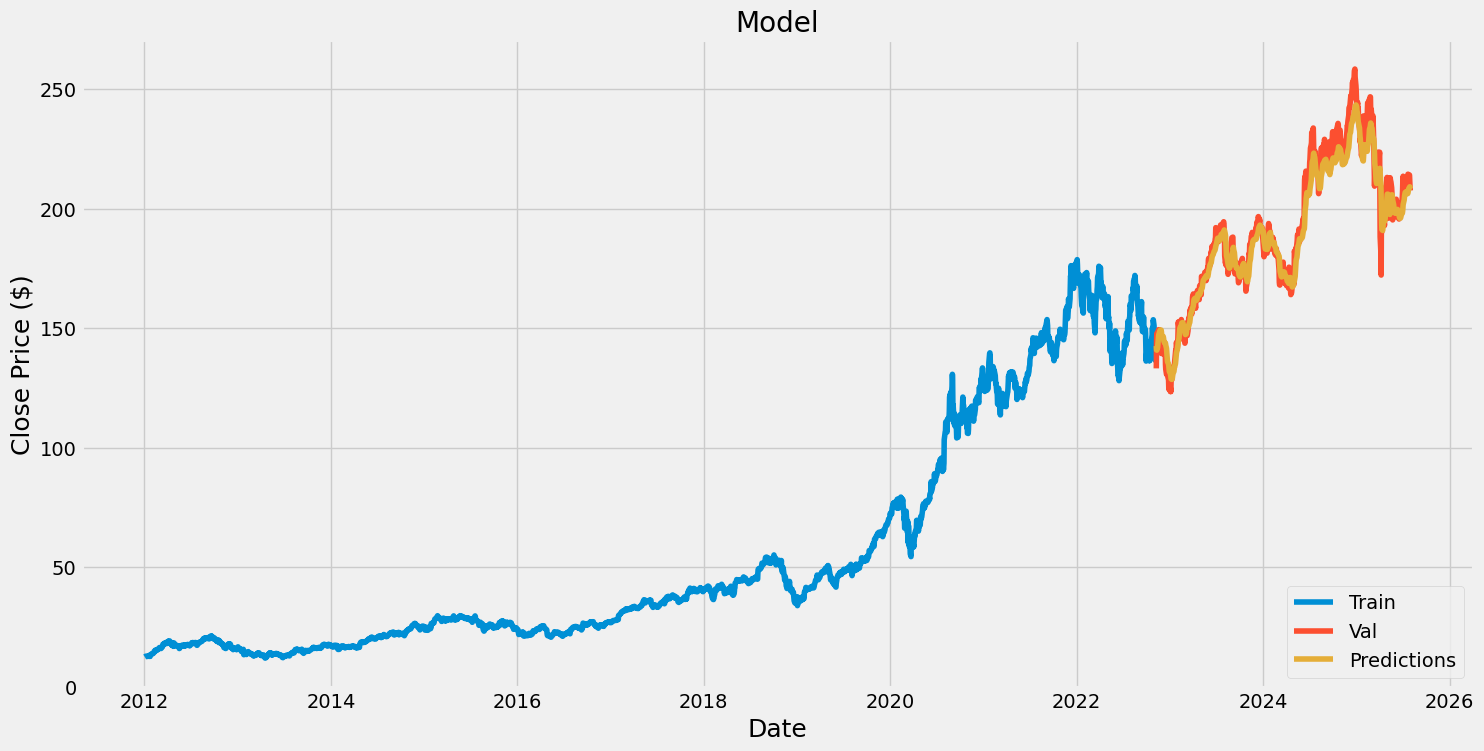

In [ ]:
# Prepare training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:].copy()

# Add predictions column
valid['Predictions'] = predictions

# Plot
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)

plt.plot(train.index, train.values, label='Train')
plt.plot(valid.index, valid.iloc[:,0], label='Val')
plt.plot(valid.index, valid['Predictions'], label='Predictions')

plt.legend(loc='lower right')
plt.show()


In [ ]:
valid

Ticker,AAPL,Predictions
Date,,
2022-11-09,133.145279,142.489746
2022-11-10,144.991806,140.847473
2022-11-11,147.785645,140.783539
2022-11-14,146.383804,141.816116
2022-11-15,148.121277,143.110229
...,...,...
2025-07-25,213.880005,208.372818
2025-07-28,214.050003,208.796692
2025-07-29,211.270004,209.129745
